In [ ]:
import torch
import torch.nn as nn


class LSTMClassifier(nn.Module):
    """
    A PyTorch-based LSTM classifier for sequence data.

    Attributes:
        input_size (int): The number of features in the input sequence.
        hidden_size (int): The number of features in the hidden state of the LSTM.
        num_layers (int): The number of stacked LSTM layers.
        num_classes (int): The number of output classes for classification.
    """

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        """
        Initializes the LSTMClassifier.

        Args:
            input_size (int): Number of features in the input sequence.
            hidden_size (int): Number of features in the hidden state.
            num_layers (int): Number of stacked LSTM layers.
            num_classes (int): Number of output classes.
        """
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define an LSTM layer
        # input_size: number of input features per time step
        # hidden_size: number of features in the hidden state
        # num_layers: number of stacked LSTM layers
        # batch_first=True means input/output tensors have shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer 1
        # Takes the hidden state from the LSTM and projects it to 1024 dimensions
        self.fc1 = nn.Sequential(
            nn.Linear(hidden_size, 1024),  # Fully connected layer
            nn.ReLU()  # Activation function
        )

        # Fully connected layer 2
        # Maps the 1024-dimensional output to the number of classes
        # Softmax activation ensures outputs represent probabilities
        self.fc2 = nn.Sequential(
            nn.Linear(1024, num_classes),  # Fully connected layer
            nn.Softmax(dim=1)  # Apply Softmax along the class dimension
        )

    def forward(self, x):
        """
        Defines the forward pass of the LSTMClassifier.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_length, input_size).

        Returns:
            Tensor: Output tensor of shape (batch_size, num_classes), representing class probabilities.
        """
        # Initialize hidden and cell states with zeros
        # Shape of h0 and c0: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Cell state

        # Pass the input sequence through the LSTM
        # out: output features from all time steps (batch_size, seq_length, hidden_size)
        # _: hidden and cell states from the last time step
        out, _ = self.lstm(x, (h0, c0))

        # Use only the output from the last time step
        # Shape of out after slicing: (batch_size, hidden_size)
        out = out[:, -1, :]

        # Pass the output through the first fully connected layer and activation
        out = self.fc1(out)

        # Pass the result through the second fully connected layer and apply Softmax
        out = self.fc2(out)

        return out

In [ ]:
from torch.utils.data import Dataset
import torch
import os
import librosa
import numpy as np


# Custom Dataset class for loading gender-specific audio recordings
class GenderDataset(Dataset):
    def __init__(self, main_dir, sample_rate=16_000):
        """
        Initializes the GenderDataset.

        Args:
        main_dir (str): Path to the main directory containing 'female' and 'male' subdirectories.
        sample_rate (int): The target sample rate for loading audio files. Default is 16 kHz.
        """
        self.main_dir = main_dir
        self.sample_rate = sample_rate

        # Splitting the recordings into female and male categories
        self.female, self.male = self.split_to_arr()

        # Combining all recordings into a single list
        self.all_rec = self.female + self.male

    def split_to_arr(self):
        """
        Lists the audio files in 'female' and 'male' subdirectories.

        Returns:
        tuple: Two lists, one for female recordings and one for male recordings.
        """
        female_recordings = os.listdir(os.path.join(self.main_dir, "female"))  # Female audio files
        male_recordings = os.listdir(os.path.join(self.main_dir, "male"))  # Male audio files
        return female_recordings, male_recordings

    def __len__(self):
        """
        Returns the total number of audio files in the dataset.

        Returns:
        int: Total count of female and male recordings.
        """
        return len(self.female) + len(self.male)

    def __getitem__(self, idx):
        """
        Fetches the MFCC feature tensor and one-hot encoded label for a given index.

        Args:
        idx (int): Index of the audio file to retrieve.

        Returns:
        tuple: A tensor of MFCC features and a one-hot encoded tensor for the label.
        """
        # Determine if the index corresponds to a female or male recording
        male_or_female = "female" if idx < len(self.female) else "male"

        # Get the file name for the corresponding index
        file = self.all_rec[idx]

        # Load the audio file and resample it to the specified sample rate
        audio, sr = librosa.load(os.path.join(self.main_dir, male_or_female, file), sr=self.sample_rate)

        # Extract MFCC features (20 coefficients)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

        # Define the maximum number of frames for 2 seconds of audio
        max_frames = 62  # Computed as 2 * 16000 / 512 (frame size of 512)
        if mfcc.shape[1] > max_frames:
            # Truncate to the maximum frame count if it exceeds the limit
            mfcc = mfcc[:, :max_frames]
        else:
            # Pad with zeros if the frame count is less than the maximum
            padding = max_frames - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, padding)), mode="constant")

        # Convert MFCC features to a PyTorch tensor and transpose it
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).T

        # Assign a label: 0 for female, 1 for male
        label = 0 if male_or_female == "female" else 1

        # Create a one-hot encoded label tensor
        label_tensor = torch.zeros(2)
        label_tensor[label] = 1

        # Return the MFCC tensor and label tensor
        return mfcc_tensor, label_tensor

Epoch 1/5: 100%|██████████| 354/354 [41:34<00:00,  7.05s/batch, train_loss=0.0898]


Epoch 1: Train Loss = 0.0898, Validation Loss = 0.0791


Epoch 2/5: 100%|██████████| 354/354 [02:49<00:00,  2.09batch/s, train_loss=0.0169]


Epoch 2: Train Loss = 0.0169, Validation Loss = 0.2023


Epoch 3/5: 100%|██████████| 354/354 [02:52<00:00,  2.05batch/s, train_loss=0.0143]


Epoch 3: Train Loss = 0.0143, Validation Loss = 0.0006


Epoch 4/5: 100%|██████████| 354/354 [02:48<00:00,  2.10batch/s, train_loss=0.0151]


Epoch 4: Train Loss = 0.0151, Validation Loss = 0.0016


Epoch 5/5: 100%|██████████| 354/354 [02:48<00:00,  2.10batch/s, train_loss=0.00413]


Epoch 5: Train Loss = 0.0041, Validation Loss = 0.0059
Test Loss: 0.0007
Losses saved to losses.json


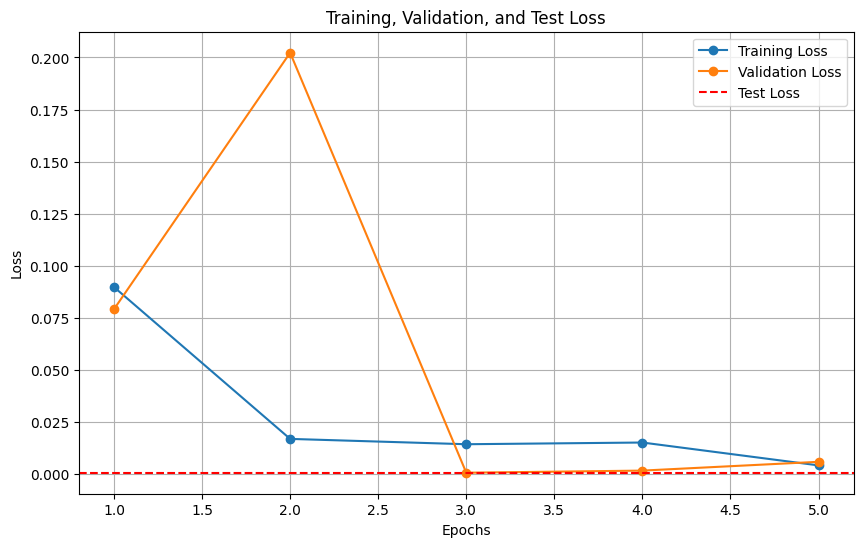

In [ ]:
import matplotlib.pyplot as plt  # For plotting graphs


from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch
import json
from tqdm import tqdm


def train(dataloader, model, device, criterion, optimizer, epochs):
    """
    Trains the model, evaluates it on the validation set, and tracks the losses.

    Args:
    dataloader (dict): Dictionary containing "train" and "val" DataLoaders.
    model (nn.Module): The model to train.
    device (torch.device): Device to use for training.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer for training.
    epochs (int): Number of epochs.

    Returns:
    tuple: Lists containing training and validation losses for each epoch.
    """
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        prog_bar = tqdm(dataloader["train"], desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")

        for audio, label in prog_bar:  # Training loop
            audio, label = audio.to(device), label.to(device)
            optimizer.zero_grad()

            outputs = model(audio)
            loss = criterion(outputs, label)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            prog_bar.set_postfix(train_loss=running_loss / len(dataloader["train"]))

        avg_train_loss = running_loss / len(dataloader["train"])
        train_losses.append(avg_train_loss)

        # Validation phase
        avg_val_loss = validate(dataloader["val"], model, device, criterion)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")

    return train_losses, val_losses


def validate(dataloader, model, device, criterion):
    """
    Evaluates the model on the validation set.

    Args:
    dataloader (DataLoader): DataLoader for the validation set.
    model (nn.Module): The model to validate.
    device (torch.device): Device to use for validation.
    criterion (nn.Module): Loss function.

    Returns:
    float: Average validation loss.
    """
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for audio, label in dataloader:
            audio, label = audio.to(device), label.to(device)
            outputs = model(audio)
            loss = criterion(outputs, label)
            val_loss += loss.item()

    return val_loss / len(dataloader)


def test(dataloader, model, device, criterion):
    """
    Tests the model on the test set and tracks the test loss.

    Args:
    dataloader (DataLoader): DataLoader for the test set.
    model (nn.Module): The model to test.
    device (torch.device): Device to use for testing.
    criterion (nn.Module): Loss function.

    Returns:
    float: Average test loss.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for audio, label in dataloader:
            audio, label = audio.to(device), label.to(device)
            outputs = model(audio)
            loss = criterion(outputs, label)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")
    return avg_test_loss


def plot_losses(train_losses, val_losses, test_loss):
    """
    Plots training, validation, and test losses.

    Args:
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    test_loss (float): Average test loss.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label="Training Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")

    # Plot the test loss as a horizontal line
    plt.axhline(y=test_loss, color="r", linestyle="--", label="Test Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training, Validation, and Test Loss")
    plt.legend()
    plt.grid()
    plt.show()


def save_losses(train_losses, val_losses, test_loss, filename="losses.json"):
    """
    Saves the training, validation, and test losses to a JSON file.

    Args:
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    test_loss (float): Average test loss.
    filename (str): Name of the JSON file to save losses.
    """
    losses = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_loss": test_loss,
    }
    with open(filename, "w") as file:
        json.dump(losses, file)
    print(f"Losses saved to {filename}")


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if __name__ == "__main__":
    # Load dataset
    dataset = GenderDataset("/content/drive/MyDrive/gender classification")

    # Split dataset into training (70%), validation (15%), and testing (15%) sets
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    dataloaders = {
        "train": DataLoader(train_set, batch_size=32, shuffle=True),
        "val": DataLoader(val_set, batch_size=32, shuffle=False),
        "test": DataLoader(test_set, batch_size=32, shuffle=False),
    }

    # Initialize the LSTM model
    model = LSTMClassifier(input_size=20, hidden_size=1024, num_layers=2, num_classes=2)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model and track losses
    train_losses, val_losses = train(dataloaders, model, device, criterion, optimizer, epochs=5)

    # Save the trained model
    torch.save(model, "sound_model.pth")

    # Test the model and track the loss
    test_loss = test(dataloaders["test"], model, device, criterion)

    # Save the losses to a JSON file
    save_losses(train_losses, val_losses, test_loss)

    # Plot the losses
    plot_losses(train_losses, val_losses, test_loss)


In [ ]:
import torch
  # This assumes untitled2.py is available
import librosa
import numpy as np
# Device setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use weights_only=False explicitly
model = torch.load("sound_model.pth", map_location=device, weights_only=False)
model.to(device)
model.eval()
def preprocess_audio(file_path, sample_rate=16000, n_mfcc=20, max_frames=62):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    if mfcc.shape[1] > max_frames:
        mfcc = mfcc[:, :max_frames]
    else:
        padding = max_frames - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, padding)), mode="constant")

    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).T.unsqueeze(0).to(device)
    return mfcc_tensor

def predict_gender(file_path):
    input_tensor = preprocess_audio(file_path)
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()
        return "Female" if prediction == 0 else "Male"

# Example usage
file_path = "/content/drive/MyDrive/gender classification/male/arctic_a0001(4).wav"  # Replace with actual path
gender = predict_gender(file_path)
print(f"Predicted Gender: {gender}")

Predicted Gender: Male
